In [32]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

import numpy as np    
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN
from sklearn.mixture import GaussianMixture 

from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics.cluster import silhouette_score, silhouette_samples, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance


In [33]:
RS = 404 # Random state/seed
pd.set_option("display.max_columns",30) # Increase columns shown

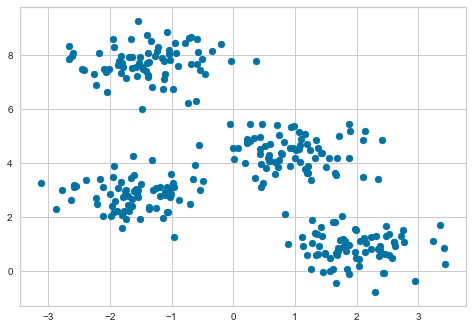

In [34]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

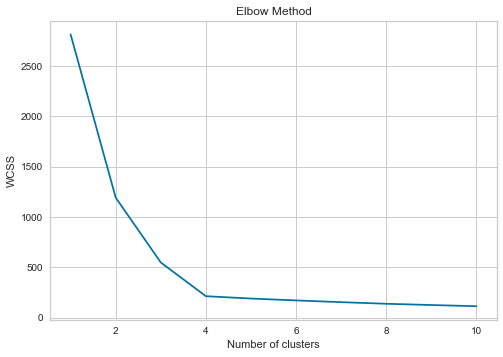

In [35]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

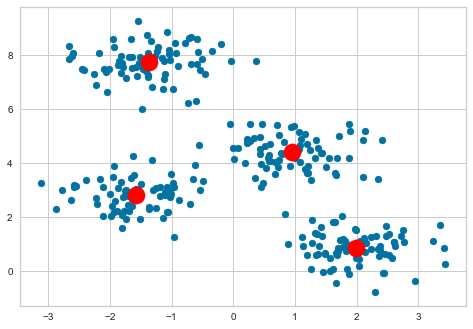

In [36]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

In [37]:
df = pd.read_csv("whd_2019.csv")
df = df.dropna(axis='columns', how='all')

In [38]:
new_df_w_continent=df.drop(['country','happiness_rank','year'],axis=1)
new_df_w_continent = new_df_w_continent.apply(lambda x: x.fillna(0),axis=0)

In [65]:
def plot_cluster(x, y, data, title='',centers=None, **kwargs):
    
    fig, ax = plt.subplots(figsize=(8,5))
    
    labels = data[kwargs.get('c')]
    nlabels = labels.nunique()
    bounds = np.arange(labels.min(),nlabels+1)
    
    # 20 distinct colors, more visible and differentible than tab20 
    # https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
    cset = ['#3cb44b', '#ffe119', '#4363d8','#e6194b', 
        '#f58231','#911eb4', '#46f0f0', '#f032e6', '#bcf60c', 
        '#fabebe', '#008080', '#e6beff','#800000', '#aaffc3'] # take 14

    cm = (mpl.colors.ListedColormap(cset, N=nlabels) if labels.min() == 0 
          else mpl.colors.ListedColormap(['#000000']+cset, N=nlabels+1))    
    
    sct = ax.scatter(x,y,data=data,cmap=cm,edgecolors='face',**kwargs)
    
    if centers is not None:
        if isinstance(centers,np.ndarray):
            for g in centers[:,[data.columns.get_loc(x),data.columns.get_loc(y)]]:
                ax.plot(*g,'*r',markersize=12, alpha=0.6)
                
        if isinstance(centers,pd.DataFrame):
            ax.scatter(x,y,data=centers,marker='D',c=centers.index.values,cmap=cm,
                       s=np.exp(centers['Life_Ladder'])*75, # scale ♦ size by Life_Ladder score 
                       #s=(labels.value_counts().sort_index()/len(labels))*np.sqrt(nlabels)*200, #scale ♦ sizes by n
                       edgecolors='black',linewidths=1,alpha=0.7)
            
        ax.set_title('(color=group, ♦size=Happiness, ♦loc = group center)')
            
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    
    fig.suptitle(title, fontsize=14)
    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8]) # 'Magic' numbers for colorbar spacing
    norm = mpl.colors.BoundaryNorm(bounds,cm.N)
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cm, norm=norm,ticks=bounds+0.5, boundaries=bounds)
    cb.set_ticklabels(bounds)

    plt.show()
    return ax

In [40]:
new_df=df.drop(['country','happiness_rank','continent','year'],axis=1)
new_df = new_df.apply(lambda x: x.fillna(0),axis=0)
new_df.head()

,happiness_score,gdp_per_capita,family,life_expectancy,freedom,generosity,government_corr,social_support
0,7.587,1.39651,1.34951,0.94143,0.66557,0.29678,0.41978,0.0
1,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,0.0
2,7.527,1.32548,1.36058,0.87464,0.64938,0.34139,0.48357,0.0
3,7.522,1.45900,1.33095,0.88521,0.66973,0.34699,0.36503,0.0
4,7.427,1.32629,1.32261,0.90563,0.63297,0.45811,0.32957,0.0


In [62]:
def plot_boxolin(x,y,data):
  
    fig,axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
    whr_grps.boxplot(column=y,by=[x],ax=axes[0]) 
    sns.violinplot(x,y,data = whr_grps,scale='area',ax=axes[1])
    axes[0].set_title(None)
    axes[0].set_ylabel(axes[1].get_ylabel())
    axes[1].set_ylabel(None)
    plt.show()
    return axes

In [63]:
def cluster(model, X, **kwargs):
   
    clust_labels = model.fit_predict(X,**kwargs)
    centers = X.assign(**{model.__class__.__name__ : clust_labels}
                      ).groupby(model.__class__.__name__,sort=True).mean() 
    
    return (clust_labels, centers)

In [66]:
def score_clusters(X,labels):
   
    scores = {'first':happiest(X,labels),
              'second':middle(X,labels),
              'third':sad(X,labels)
             }
    return scores

In [44]:
# Model Data

n_clusters: 2
 {'silhouette': 0.375757504448296, 'calinski_harabasz': 647.4435793355009, 'davies_bouldin': 1.0665939143958498}
n_clusters: 3
 {'silhouette': 0.43455564941987274, 'calinski_harabasz': 734.123604096246, 'davies_bouldin': 0.8126305884446058}
n_clusters: 4
 {'silhouette': 0.3969253840867944, 'calinski_harabasz': 711.6235551885156, 'davies_bouldin': 0.8308094981499737}
n_clusters: 5
 {'silhouette': 0.4015380510067461, 'calinski_harabasz': 765.3626102568466, 'davies_bouldin': 0.8208377786041693}
n_clusters: 6
 {'silhouette': 0.3923902386173055, 'calinski_harabasz': 769.3415840731234, 'davies_bouldin': 0.8634252507568898}
n_clusters: 7
 {'silhouette': 0.3734567584764678, 'calinski_harabasz': 792.2057993658522, 'davies_bouldin': 0.8721320987776302}
n_clusters: 8
 {'silhouette': 0.34473279825950626, 'calinski_harabasz': 767.7471173228372, 'davies_bouldin': 0.9355130499054427}
n_clusters: 9
 {'silhouette': 0.334556875796612, 'calinski_harabasz': 758.5755626979999, 'davies_bouldin

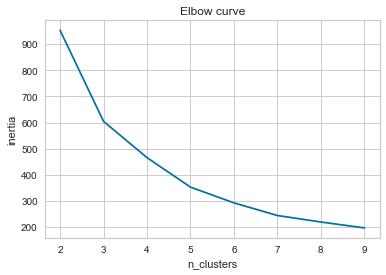

In [53]:
distortions = []
for n in range(2,10):
    model = KMeans(n_clusters=n,random_state=RS).fit(new_df)
    distortions.append(model.inertia_)
    labs = model.labels_
    print(f'n_clusters: {n}\n',score_clusters(new_df,labs))
    
fig,ax = plt.subplots(figsize=(6, 4))
ax.plot(range(2,10),distortions)
ax.set(**{'title':'Elbow curve','ylabel':'inertia','xlabel':'n_clusters'})
plt.show()

In [67]:
km = KMeans(n_clusters=3,random_state=RS)
clabels_km, cent_km = cluster(km, new_df)
new_df ['KMeans'] = clabels_km
cent_km

,happiness_score,gdp_per_capita,family,life_expectancy,freedom,generosity,government_corr,social_support
KMeans,,,,,,,,
0,4.271569,0.556693,0.489821,0.399363,0.337080,0.220332,0.102064,0.340119
1,6.176817,1.194450,1.155596,0.727002,0.458095,0.244611,0.155775,0.000000
2,6.084929,1.118408,0.000000,0.801403,0.466898,0.180128,0.121230,1.375929


KeyError: 'Life_Ladder'

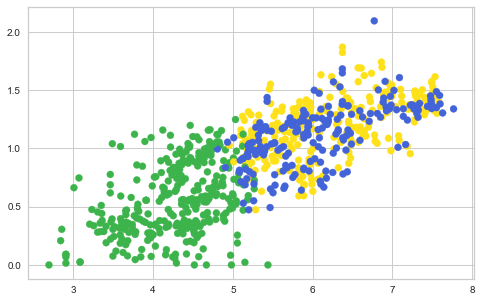

In [68]:
plot_cluster('happiness_score', 'gdp_per_capita', new_df, centers=cent_km, title='K-Means Cluster', c='KMeans')
